# Cambio Relativo entre Observación  y Predicción

Se estudia la diferencia relativa de las observaciones de la calidad del aire del 2020 respecto a los valores esperados según los datos meteorológicos medidos a partir del modelo predictivo.

$$
RC_i (\%)  = 100 \cdot \frac{C_{i, obs} - C_{i, pred}}{C_{i, pred}}
$$

donde $C_i$ es la concentración del contaminante en el día $i$ del año.

In [1]:
library(tidyverse)
library(ggplot2)

setwd("~/Repositories/AirQualityCOVID/")
source("src/Analysis/functions.R")

source("src/functions.R")

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=5,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
html.variable <- list("no" = "NO",
                      "no2" = "NO<sub>2</sub>",
                      "o3" = "O<sub>3</sub>",
                      "pm10" = "PM10",
                      "pm2.5" = "PM2.5"
                     )
r.variable <- c("no" = expression(NO),
                     "no2" = expression(NO[2]),
                     "o3" = expression(O[3]),
                     "pm10" = expression(PM10),
                     "pm2.5" = expression(PM2.5)
                    )

In [4]:
periods <- list(
            # Prelockdown
            pre.lockdown = lubridate::ymd("2020-01-01"),

            # lockdown
            lockdown = lubridate::ymd("2020-03-14"),
            #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

            # poslockdown
            fases = lubridate::ymd("2020-05-01"),
            normalidad = lubridate::ymd("2020-06-21"),

            # New lockdown
            new.lockdown = lubridate::ymd("2020-10-25"),
            end.year = lubridate::ymd("2020-12-31")
        )
    
   

In [37]:
data.df <- read.csv("data/Results/predictions.csv") %>%
            data.as.datetime(column = "date", FUN="ymd")
head(data.df)

,site,variable,date,obs,pred
,<fct>,<fct>,<date>,<dbl>,<dbl>
1,es0041a,no2,2020-01-01,39.12500,57.46636
2,es0041a,no2,2020-01-02,50.62500,55.85742
3,es0041a,no2,2020-01-03,50.38095,54.56358
4,es0041a,no2,2020-01-04,42.50000,52.28828
5,es0041a,no2,2020-01-05,38.75000,52.17070
6,es0041a,no2,2020-01-06,39.91667,56.06852


In [26]:
load("data/data_AQ.rda")

old <- data_AQ %>%
            openair::timeAverage(avg.time = "day", 
                                 type = c("variable", "site")) %>% 
            mutate(date=lubridate::as_date(date)) %>%
            filter(lubridate::year(date) < 2020) %>% 
            select(date, site, variable, value)
lubridate::year(old$date) <- 2020

old.mean <- old %>%
                group_by(date, variable, site) %>%
                summarise(value = mean(value, na.rm=T)) %>%
                rename(previous.years = value)

`summarise()` has grouped output by 'date', 'variable'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'periods', 'variable'. You can override using the `.groups` argument.



In [46]:
results <- merge(data.df,
                 old.mean,
                 by = c("date", "variable", "site"),
                 all.y = T, all.x=F
                ) %>%
            sep.periods(periods) %>%
            mutate(diff = relative.change(obs,
                                          pred),
                   diff.hist = relative.change(obs,
                                               previous.years)
                  )

diff.results <- results  %>%
        group_by(periods, variable, site) %>%
        summarise(mean.pred = mean(diff, na.rm=T),
                  mean.hist = mean(diff.hist, na.rm=T),
                  std.pred = sd(diff, na.rm=T),
                  std.hist = sd(diff.hist, na.rm=T))

`summarise()` has grouped output by 'periods', 'variable'. You can override using the `.groups` argument.



Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."


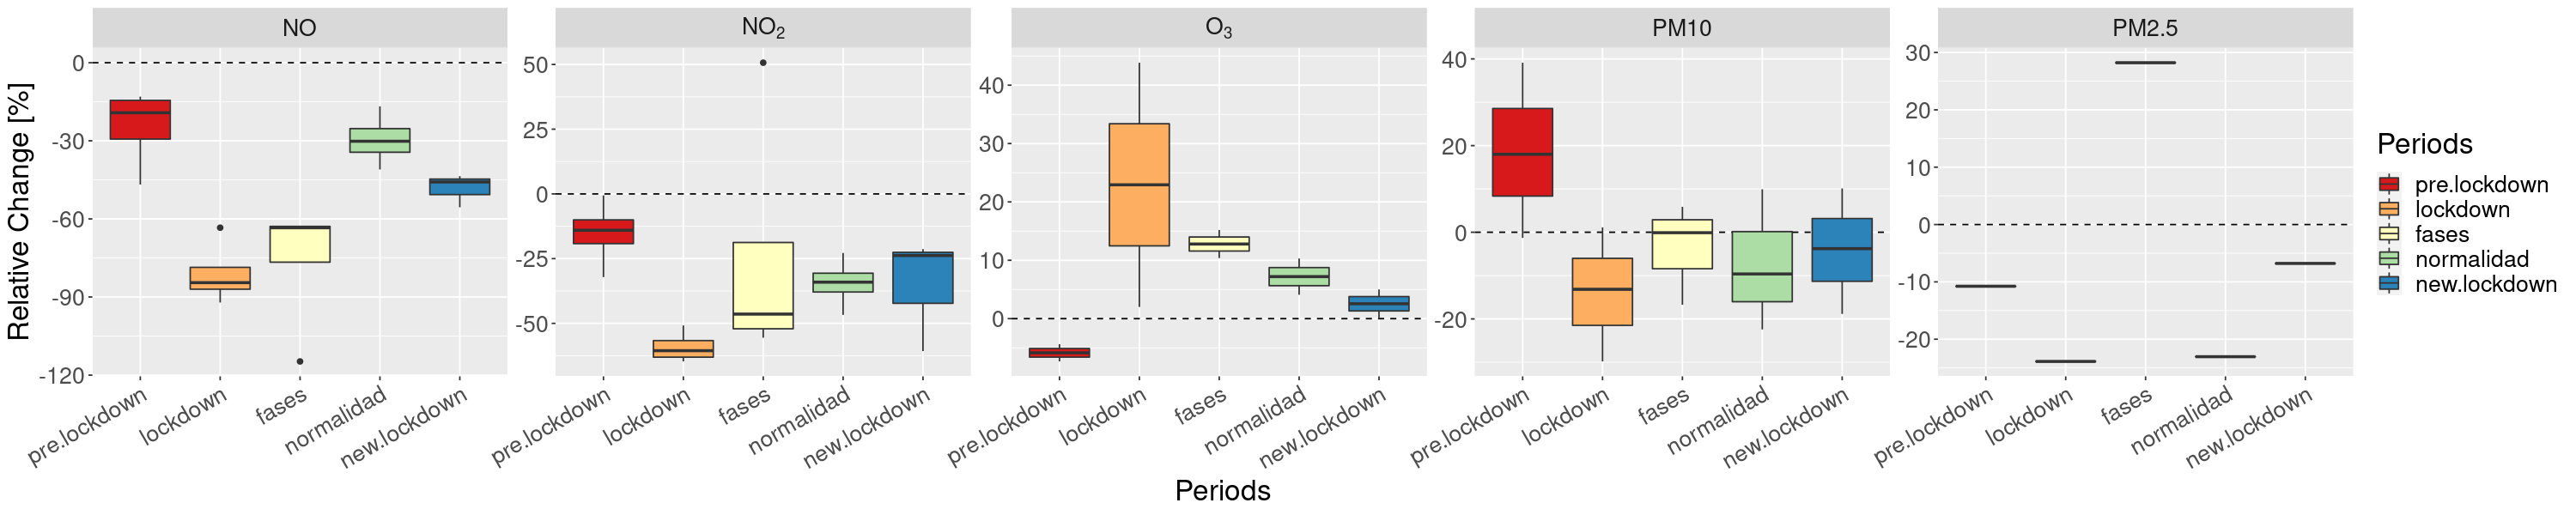

In [49]:
plot.df <- diff.results

plot.df$periods <- factor(plot.df$periods,
                          levels = names(periods),
                          ordered = TRUE)
plot.df$variable <- factor(plot.df$variable, 
                           labels=r.variable)

ggplot(plot.df) +
    geom_hline(yintercept=0, linetype="dashed", color = "black") +
    geom_boxplot(aes(x=periods, y=mean.pred, fill=periods)) + 
    theme(text = element_text(size=20),
          axis.text.x = element_text(angle=30, hjust=1)
         ) +
    scale_y_continuous(name="Relative Change [%]") +
    scale_x_discrete(name="Periods")+
    #scale_fill_discrete(name="Periods") +
    scale_fill_brewer(name="Periods", palette="Spectral") +
    facet_wrap(~variable, ncol=5, scale="free_y", 
               labeller = labeller(variable=label_parsed))

In [ ]:
ggsave(last_plot(), filename="Plots/Results/vs_Predictions/boxplot.png", width=10, height=8)

In [ ]:
cleaned.df <- data.frame()
outlier.df <- data.frame()

for (pr in levels(as.factor(change.municipios$periods))) {
    for (pll in levels(as.factor(change.municipios$variable))) {
        dat.rw <- change.municipios %>%
                    filter(periods == pr,
                           variable == pll
                          ) %>% data.frame
        
        outlier <- boxplot.stats(dat.rw$mean)$out
        if (length(outlier) > 0) {
            in.position <- -which(dat.rw$mean %in% outlier)
        } else {
            in.position <- which(dat.rw$mean %in% dat.rw$mean)
        }
            
        cleaned.df <- rbind(cleaned.df,
                            dat.rw[in.position, ])
        outlier.df <- rbind(outlier.df,
                            dat.rw[-in.position, ])
    }
}

In [ ]:
head(outlier.df) %>% select(-latitude, -longitude)

In [ ]:
cleaned.df %>% 
    filter(
           variable == "no2",
    #       periods == "lockdown"
          ) %>%
    group_by(periods, variable) %>%
    summarise(Mean = mean(mean, na.rm=T),
              Median = median(mean, na.rm=T),
              Q3 = quantile(mean, na.rm = T, 0.75),
              Q1 = quantile(mean, na.rm = T, 0.25),
              IQR = Q3-Q1
             )

---

In [ ]:
library(leaflet)
library(leaflet.extras)
library(htmlwidgets)
library(htmltools)

In [ ]:
variable <- "no2"

In [ ]:
rr <- tags$div(HTML(paste(
    "<h3>", html.variable[[variable]],"</h3>"))
 ) 

beatCol <- colorNumeric(palette = 'RdYlGn',
                        domain = c(min(cleaned.df$mean, na.rm=T), 
                                   -min(cleaned.df$mean, na.rm=T)),
                        na.color = "transparent",
                        reverse = T,
                        
                       )

map <- leaflet(cleaned.df,
               options = leafletOptions(minZoom = 5, 
                                        maxZoom = 9)) %>%
            addControl(rr, position = "topright")  %>%
            addProviderTiles(providers$CartoDB.Positron)%>% 
            #addTiles() %>% # Add default OpenStreetMap map tiles
            addLayersControl(position="bottomleft", 
                             baseGroups = names(periods)[-6],
                             options = layersControlOptions(
                                         collapsed = FALSE
                                         )
                            )%>% 
            addCircleMarkers(~longitude, 
                             ~latitude, 
                             color=~beatCol(mean),
                             radius=10,
                             fillOpacity=0.9,
                             stroke=FALSE,
                             group=~periods,
                             popup = paste(cleaned.df$Municipio, ": ",
                                           trunc(cleaned.df$mean), "%", sep="")
                            )%>%
            addLegend("topleft", 
                       pal = beatCol, 
                       values = ~mean,
                       title = "Relative Change %",
                       labFormat = labelFormat(suffix = "%"),
                       opacity = 1,
                       )

map

In [ ]:
library(htmlwidgets)
saveWidget(map, file="Plots/Results/vs_Observations/change_map.html")